Data Science + Social Justice

Topic Modeling

Pratik Sachdeva, Renata Barreto

Notebook Based On: 

Tom van Nuenen 
(tom.van_nuenen@kcl.ac.uk)

Aniket Kesari 
(https://github.com/dlab-berkeley/Computational-Social-Science-Training-Program/blob/master/Natural%20Language%20Processing/Exploratory%20and%20Unsupervised%20Methods/EDA%20and%20Unsupervised%20Methods.ipynb)


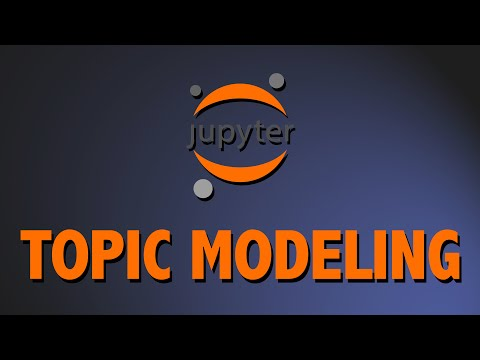

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('ka8k32dszuY', width=640, height=360)

# Topic modeling

This notebook introduces topic modeling. Topic modeling is a type of statistical modeling for the discovery of abstract "topics" that occur in a collection of documents. It is frequently used in NLP to aid the discovery of hidden semantic structures in a collection of texts.

Before you start, please read this post for an explainer of how topic modeling (and LDA, which is just one form of topic modeling) works.

Specifically, we'll implement Latent Dirichlet Allocation (LDA), which is a classic method for topic modeling. Topic models can help us uncover structure within a text. Specifically it does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document. Let's reload our cfpb dataset and look at "checkings or savings account" and "student loan" products this time:

## Loading the data

In [2]:
import os
# We include two ../ because we want to go two levels up in the file structure
#Python method chdir() changes the current working directory to the given path.
#It returns None in all the cases.
os.chdir("../../data")

In [19]:
#AttributeError: module 'pyarrow' has no attribute '__version__'

# ! yes  | conda install -c conda-forge pyarrow

In [17]:
import pandas as pd

df = pd.read_csv('aita_sub_top_sm_pos_lemmas_topics.csv')

AttributeError: module 'pyarrow' has no attribute '__version__'

In [ ]:
df.head(3)

Topic modeling uses a simplifying assumption known as the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.

Let's start by creating our tf-idf matrix:

In [ ]:
X = df['selftext']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

Now that we have a dense matrix, let's apply our LDA model. The key hyperparameter here is the n_components argument. Let's start with 5, and then print out our topics to see what we get.

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

We have 5 topics! Some seem to be sensible (i.e. topic 2 seems to be about banking while topic 3 is about student loans), but notice that the computer doedsn't find the right "topic names" for us automatically - so there is still a role for humans to interpret and make sense of the output.

## Topic weights
One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the Pandas dataframe.

Topic modeling has several practical applications. One of them is to determine what topic a Reddit post is about. To figure this out, we find the topic number that has the highest percentage contribution to that thread

First get the topic distribution array.

In [ ]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

And then we'll merge back with original dataframe:

In [18]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(cfpb.reset_index())
df_w_topics.head()

NameError: name 'pd' is not defined

In [ ]:
grouped = df_w_topics.groupby('Product')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

Topics 2 and 3 seem to have a lot of separation between checkings or savings account and student loans. Let's plot them:

In [ ]:
sns.displot(df_w_topics, x=df_w_topics[2], hue = "Product", kind = 'kde', fill = 'true')
plt.show()

In [ ]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "Product", kind = 'kde', fill = 'true')
plt.show()

This is a very clean separation! These two topics would be good candidates to pass to a supervised learning algorithm if we were interested in predicting the Product.

## Tweaking hyperparameters

Next, let's change some hyperparameters. This can also determine how interpretable our topic models become.
Try retraining the LDA witha different number of topics, say 10. What do you notice? 

In [ ]:
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

# Reflection: The hermeneutics of topic modeling

One thought to end with: for most topic models you will create, it will be hard to apply a meaningful interpretation to each topic. Not every topic will have some meaningful insight "fall out of it" upon first inspection. This is a typical issue in machine learning, which can pick up on patterns that might not make sense to humans.

It is an open question to which extent you should let yourself be surprised by particular combinations of words in a topic, or if topic models primarily should follow the intuitions you already have as a researcher. What makes for a "good" topic model probably straddles the boundaries of surprise and expectation.

# Challenge (Optional)

The final and most important thing we can do to find optimal scores is to play around with the amount of topics our model creates. One way to do this is to build many LDA models with different values of number of topics (k), and then pick the one that gives the highest coherence value. Choosing a ‘k’ at the end of a rapid growth of topic coherence usually yields meaningful and interpretable topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

This compute_coherence_values() function trains multiple LDA models, provides the models, and tells you their corresponding coherence scores.

Also note the docstring I create here: these are documentation for the functions we create. It describes what a function does, and can be called using help(function_X).

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Tokenized text (list of lis of str)
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = int(limit/step - start/step)
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, iterations=50, passes=10, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values